# PREDICTOR FOR 10 UNBALANCED COMPLETE GENES


Training starting from best saved model

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, precision_score, cohen_kappa_score, classification_report
import seaborn as sns; sns.set()
from keras import backend as K


In [3]:
#CHECK GOOGLE COLAB
GOOGLE_COLAB=False
if 'google.colab' in str(get_ipython()):
  GOOGLE_COLAB=True  
  print('Running on CoLab')
else:
  print('Not running on CoLab')

#CHECK GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Num GPUs Available: {}'.format(len(tf.config.list_physical_devices('GPU'))))
  print('Found GPU at: {}'.format(device_name))
  gpu_info = !nvidia-smi
  gpu_info = '\n'.join(gpu_info)
  if gpu_info.find('failed') >= 0:
     print('Not connected to a GPU')
  else:
     print(gpu_info)


Not running on CoLab
Num GPUs Available: 1
Found GPU at: /device:GPU:0
Mon Feb 27 16:07:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.78       Driver Version: 512.78       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   70C    P3    N/A /  N/A |   1921MiB /  2048MiB |     50%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                 

In [7]:
########################################
# PARAMS
########################################
padding=True
model_name = 'TFM_LSTMBidiAttention'
fname = 'hg38_10_GENES_COMPLETOS_Pad_W50_CODED2CH.csv'

numchannels=2

if numchannels==3:
   categories_size=60
else:
   categories_size=20

if padding==True:
    categories_size=categories_size+1

if GOOGLE_COLAB==False:
    data_dir = '../../data/datasets/ALL_HG38/W50'
    models_dir = './SAVED_MODELS'

else:
    from google.colab import drive
    drive.mount('/content/drive')
    import sys
    sys.path.insert(0,'/content/drive/MyDrive/ColabNotebooks')    
    data_dir  = '/content/drive/MyDrive/DATASETS/ALL_HG38/W50'
    models_dir= '/content/drive/MyDrive/MODELS'
#########################################

In [8]:
saved_model =  model_name+'.h5'
savedmodelfile = os.path.join(models_dir, saved_model)
print("MODEL FILE: {}".format(savedmodelfile))

MODEL FILE: ./SAVED_MODELS\TFM_LSTMBidiAttention.h5


In [9]:
datafile = os.path.join(data_dir, fname)
print("DATASET: {}".format(datafile))
dataraw = pd.read_csv(datafile,sep=";")
print("shape dataraw={}".format(dataraw.shape))

DATASET: ../../data/datasets/ALL_HG38/W50\hg38_10_GENES_COMPLETOS_Pad_W50_CODED2CH.csv
shape dataraw=(17005, 104)


In [10]:
#dataset=dataraw[dataraw.columns[3:len(dataraw.columns)]]
X=dataraw.iloc[:,3:]
Y=dataraw['EDITING']

x_test=X
y_test=Y

print("x_test.shape={}".format(x_test.shape))
print("y_test.shape={}".format(y_test.shape))
print("TEST LABELS:")
print(y_test.value_counts())


x_test.shape=(17005, 101)
y_test.shape=(17005,)
TEST LABELS:
0    16803
1      202
Name: EDITING, dtype: int64


Recover saved model

In [11]:
#Load the trained model from disk
import os.path

if os.path.exists(savedmodelfile):
    model = tf.keras.models.load_model(savedmodelfile)
    # Show the model architecture
    model.summary()
else:
    print("ERROR model {} nor found ".format(savedmodelfile))           



Model: "TFM_LSTMBidiAttention"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 INPUTS (InputLayer)            [(None, 101, 21)]    0           []                               
                                                                                                  
 LSTM_BI (Bidirectional)        (None, 101, 512)     569344      ['INPUTS[0][0]']                 
                                                                                                  
 dropout_2 (Dropout)            (None, 101, 512)     0           ['LSTM_BI[0][0]']                
                                                                                                  
 dense_2 (Dense)                (None, 101, 1)       513         ['dropout_2[0][0]']              
                                                                              

In [13]:
#PREDICTIONS
#DataGenerator converts on the fly from raw data to one-hot
from rnaed import DataGenerator

num_nucleosides = x_test.shape[1]
num_tokens = categories_size

pred_generator = DataGenerator(x_test, y_test,  batch_size=1,seq_size=num_nucleosides, categories_size=categories_size, shuffle=False )
model_prediction = model.predict(pred_generator,verbose=1)
model_prediction_binary = (model_prediction > 0.5).astype("int32")

17005/17005 [==============================] - 736s 43ms/step


In [14]:
print(x_test.shape)
print(y_test.shape)
print(model_prediction.shape)
print(model_prediction_binary.shape)

(17005, 101)
(17005,)
(17005, 1)
(17005, 1)


In [15]:
#METRICS QUALITY CLASSIFICATION

print("MODEL "+model_name+"\n---------------------------------")
kappa = cohen_kappa_score(y_test, model_prediction_binary)
print ('Kappa:',round(kappa,3))
print(classification_report(y_test, model_prediction_binary))

MODEL TFM_LSTMBidiAttention
---------------------------------
Kappa: 0.245
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     16803
           1       0.15      0.96      0.26       202

    accuracy                           0.94     17005
   macro avg       0.58      0.95      0.61     17005
weighted avg       0.99      0.94      0.96     17005



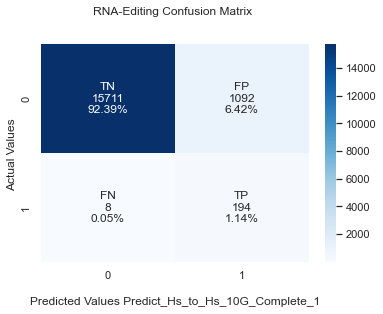

In [18]:
from sklearn.metrics import confusion_matrix, precision_score, cohen_kappa_score, classification_report
import seaborn as sns; sns.set()
# PLOT CONFUSION MATRIX
# Tutorial: https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/
plt.figure()

cm = confusion_matrix(y_test,model_prediction_binary)

group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

ax.set_title('RNA-Editing Confusion Matrix \n\n');
ax.set_xlabel('\nPredicted Values '+ 'Predict_Hs_to_Hs_10G_Complete_1')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
#ax.xaxis.set_ticklabels(['False','True'])
#ax.yaxis.set_ticklabels(['False','True'])
plt.show()